In [179]:
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) *error**k *(1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  


1.0

In [459]:
#MajorityVoteClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value 
                                  for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.lae = LabelEncoder()
        self.subset=[]
        for clf in self.classifiers:
            fitted_clf = clf.fit(X, self.lae.fit_transform(y))
            #print(clf.predict_proba(X))
            self.subset.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote=='classlabel':
            clf_label = np.asarray([clf.predict(X)
                        for clf in self.subset])
            y_pred1 = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)), axis=0, arr=clf_label)
            y_pred = self.lae.inverse_transform(y_pred1)
        elif self.vote == 'probability':
            y_pred1 = np.argmax(self.predict_proba(X), axis=1)
            y_pred = self.lae.inverse_transform(y_pred1)
        return y_pred
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.subset])
        avg_proba = np.average(probas,
                               axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
        for name, step in six.iteritems(self.named_classifiers):
            for key, value in six.iteritems(step.get_params(deep=True)):
                out['%s__%s' % (name, key)] = value
        return out

In [460]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y1 = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.5, random_state=1)

In [461]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['pca', PCA()],
                  ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['pca', PCA()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    score = cross_val_score(estimator=clf,
                           X=X_train, y=y_train, cv=10, scoring='roc_auc')
    #clf.fit(X_train, y_train)
    #print(clf.predict_proba(X_train))
    print("ROC_AUC: %0.2f (+/- %0.2f) [%s]"
         %(score.mean(), score.std(), label))
    

10-fold cross validation:

ROC_AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC_AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC_AUC: 0.93 (+/- 0.10) [KNN]


In [462]:
my_vc = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels+=['Majority Voting']
my_vc.fit(X_train, y_train)
print(my_vc.predict(X_train))
for clf, label in zip([pipe1, pipe2, pipe3, my_vc], clf_labels):
    score = cross_val_score(estimator=clf,
                           X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC_AUC: %0.2f (+/- %0.2f) [%s]"
         %(score.mean(), score.std(), label))

[0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0
 0 1 1 0 0 1 1 0 1 0 1 0 0]
ROC_AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC_AUC: 0.93 (+/- 0.10) [Decision Tree]
ROC_AUC: 0.93 (+/- 0.10) [KNN]
ROC_AUC: 0.97 (+/- 0.10) [Majority Voting]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


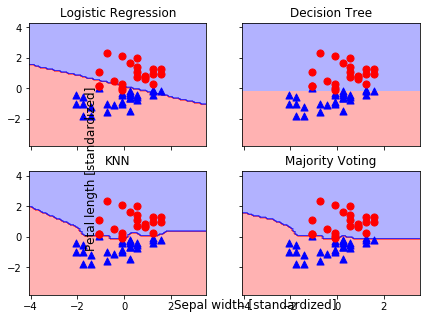

In [473]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from itertools import product
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
xmin, xmax = X_train_std[:,0].min()-2,X_train_std[:,0].max()+2 
ymin, ymax = X_train_std[:,1].min()-2,X_train_std[:,1].max()+2
xx,yy = np.meshgrid(np.arange(xmin, xmax, 0.1),
                      np.arange(ymin, ymax, 0.1))
colors = ["red", "blue", "lightgreen", "gray", "cyan"]
cmap = ListedColormap(['red', 'blue'])
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [pipe1, clf2, pipe3, my_vc], clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3,cmap=cmap)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [61]:
#bagging
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label']!=1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
lae = LabelEncoder()
y = lae.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=1)

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,
                        max_samples=1.0, max_features=1.0, bootstrap=True, 
                        bootstrap_features=False, n_jobs=1, random_state=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [104]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


In [94]:
import numpy as np
np.array(bag.estimators_samples_).shape

(500, 71)

In [77]:
X_train.shape[1]

2

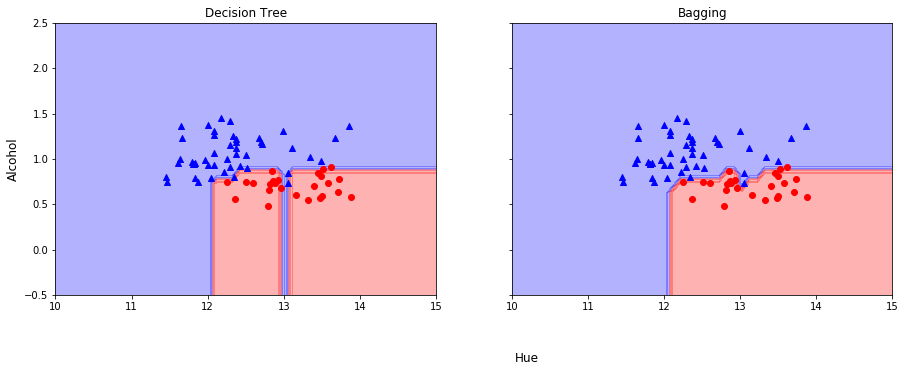

In [141]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'red'])
xmin, xmax = X_train[0].min()-2, X_train.max()+2
ymin, ymax = X_train[1].min()-2, X_train.max()+2
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1),
                     np.arange(ymin, ymax, 0.1))
fig, ax = plt.subplots(nrows=1, ncols=2,sharex='col', sharey='row', figsize=(15, 5))
for idx, clf, tt in zip([0, 1],
                        [tree, bag], 
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    z = z.reshape(xx.shape)
    ax[idx].contourf(xx, yy, z, alpha=0.3, cmap=cmap)
    ax[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue', marker='^')
    ax[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='red', marker='o')
    ax[idx].set_title(tt)
    ax[idx].set_xlim(10, 15)
    ax[idx].set_ylim(-0.5, 2.5)
ax[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

In [148]:
#AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=5)
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1, 
                         random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.854


In [149]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.833


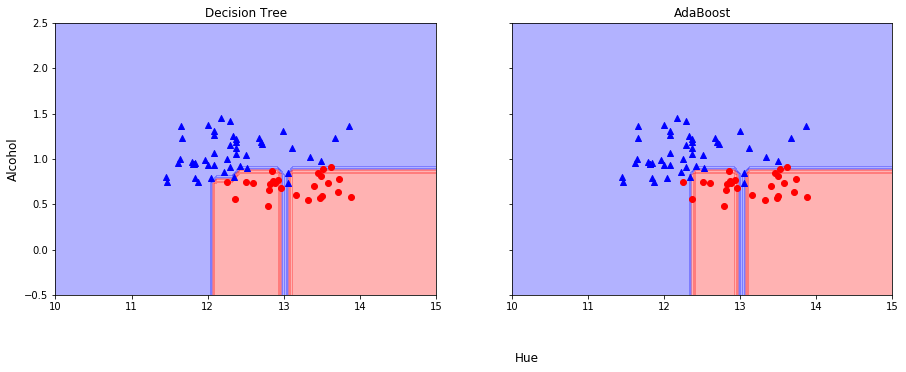

In [150]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'red'])
xmin, xmax = X_train[0].min()-2, X_train.max()+2
ymin, ymax = X_train[1].min()-2, X_train.max()+2
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1),
                     np.arange(ymin, ymax, 0.1))
fig, ax = plt.subplots(nrows=1, ncols=2,sharex='col', sharey='row', figsize=(15, 5))
for idx, clf, tt in zip([0, 1],
                        [tree, ada], 
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    z = z.reshape(xx.shape)
    ax[idx].contourf(xx, yy, z, alpha=0.3, cmap=cmap)
    ax[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue', marker='^')
    ax[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='red', marker='o')
    ax[idx].set_title(tt)
    ax[idx].set_xlim(10, 15)
    ax[idx].set_ylim(-0.5, 2.5)
ax[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
docs = np.array([
    ['The', 'sun', 'is' ,'shining'],
    ['The', 'weather', 'is','sweet'],
    ['The', 'sun', 'is', 'shining', 'and', 'the', 'weather', 'is', 'sweet']])
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

AttributeError: 'list' object has no attribute 'lower'